## Links
https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/deploy-models-managed

https://learn.microsoft.com/en-us/azure/ai-foundry/how-to/healthcare-ai/deploy-medimageparse?tabs=medimageparse

https://github.com/microsoft/healthcareai-examples/blob/main/azureml/medimageparse/medimageparse_segmentation_demo.ipynb

https://github.com/Azure/azureml-examples/blob/main/sdk/python/foundation-models/healthcare-ai/medimageparse/mip-deploy.ipynb

In [ ]:
!pip install matplotlib
!pip install azure-ai-ml
!pip install azure-identity

In [ ]:
from azure.ai.ml import MLClient
from azure.identity import InteractiveBrowserCredential

workspace_ml_client = MLClient(
    credential=InteractiveBrowserCredential(
        tenant_id="<your-tenant-id>"
    ),
    subscription_id="<your-subscription-id>",
    resource_group_name="<your-resource-group-name>",
    workspace_name="<your-workspace-name>",
)

In [ ]:
import time, sys
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    ProbeSettings,
)

# Make the endpoint name unique
timestamp = int(time.time())
online_endpoint_name = "<your-endpoint-name>"

# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    auth_mode="key",
)
workspace_ml_client.online_endpoints.begin_create_or_update(endpoint).wait()

In [ ]:
model_name = "azureml://registries/azureml/models/MedImageParse/versions/13" 

# Create an unique deployment name
deployment_name = "<your-deployment-name>"

demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=model_name,
    instance_type="Standard_NC40ads_H100_v5",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=1000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=1000,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {"<your-deployment-name>": 100}
workspace_ml_client.online_endpoints.begin_create_or_update(endpoint).result()

Check: endpoint louise-model-aus-endpoint exists


....................................................................................................................................................................................................................................................................

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://louise-model-aus-endpoint.australiaeast.inference.ml.azure.com/score', 'openapi_uri': 'https://louise-model-aus-endpoint.australiaeast.inference.ml.azure.com/swagger.json', 'name': 'louise-model-aus-endpoint', 'description': None, 'tags': {}, 'properties': {'createdBy': 'Louise Han', 'createdAt': '2025-08-15T04:07:14.732363+0000', 'lastModifiedAt': '2025-08-15T04:34:40.919621+0000', 'azureml.onlineendpointid': '/subscriptions/a915ba88-127a-43f4-96aa-365930561770/resourcegroups/jingruhan-rg/providers/microsoft.machinelearningservices/workspaces/louise-medimageparse-model-aus/onlineendpoints/louise-model-aus-endpoint', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/a915ba88-127a-43f4-96aa-365930561770/providers/Microsoft.MachineLearningServices/locations/australiaeast/mfeOperationsStatus/oeidp:e0c5bf44-ee02-44cc-823e-623f35cb1b41:328e634b-f37d-4c9a-

In [4]:
endpoint_name = online_endpoint_name
deployment_name = deployment_name

In [7]:
import json
import base64
import matplotlib.pyplot as plt


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


sample_image = "1.png"
data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [
                base64.encodebytes(read_image(sample_image)).decode("utf-8"),
                # 乳腺病理中的肿瘤细胞和炎性细胞
                "neoplastic cells in breast pathology & inflammatory cells",
                # 找到细胞病理中的细菌
                # "Find all bacterial regions in the cell smear, the purple parts are bacteria.",
            ]
        ],
    }
}
data_json = json.dumps(data)

# Create request json
request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(data, request_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


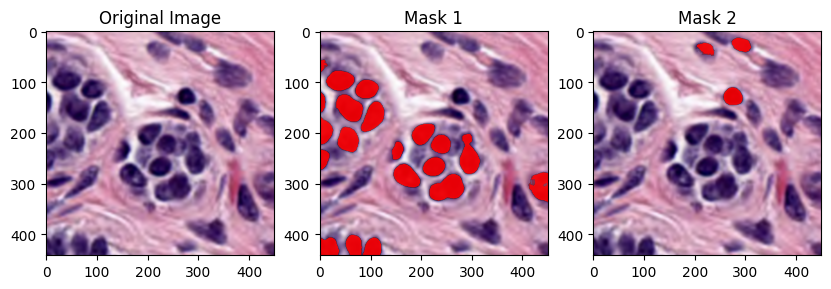

In [8]:
import sys

sys.path.append(".")
from mip_utils import plot_segmentation_masks, decode_json_to_array

# Score the sample_score.json file using the online endpoint with the azureml endpoint invoke method
response = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
result_list = json.loads(response)
image_features_str = result_list[0]["image_features"]
image_features = decode_json_to_array(image_features_str)

# Plot feature over image
sample_image_arr = plt.imread(sample_image)
plot_segmentation_masks(sample_image_arr, image_features)

# 💥Remember to delete the Endpoint or Deployment if not using it.